In [22]:
# import networkx
import lovelyplots
import networkx as nx
import numpy as np
import rustworkx as rx
import scienceplots
from rustworkx.visualization import graphviz_draw, mpl_draw
from scipy.optimize import minimize

from corral_crowding.allocation_optimizer import GateFidelityOptimizer
from corral_crowding.detuning_fit import compute_infidelity_parameters, decay_fit
from corral_crowding.module_graph import QuantumModuleGraph
from scipy.stats import gmean

In [23]:
module_list = [
    # (5, 0),
    # (5, 1),
    # (5, 2),
    # (5, 3),
    (4, 0),
    (4, 1),
    (4, 2),
    # (3, 0),
    # (3, 1),
    # (2, 0),
]

# I enforce monotonicity because of instability in the optimizer
# moreover, each less gate should be a strict subset of former solution
# so if cant find a better solution, you just havent found it yet.
# Keep track of the last valid average to enforce monotonicity
last_avg = None
averages = []
worsts = []

for module_ij in module_list:
    n, k = module_ij
    module = QuantumModuleGraph(num_qubits=n)
    optimizer = GateFidelityOptimizer(
        module,
        min_bare_space_ghz=0.2,
        lambdaq=0.08,
        eta=1.8,
        g3=60e6,
        qubit_bounds=(3.3, 5.7),
        snail_bounds=(4.2, 4.7),
        use_lifetime=True,
        drop_k=k,
    )

    while True:
        opt_frequencies, opt_cost = optimizer.optimize_frequencies()
        vals = optimizer.get_final_infidelities()
        avg = np.mean(vals)
        worst = np.max(vals)

        # # Ensure avg is strictly greater than last_avg
        # if last_avg is not None and np.abs(avg - last_avg) <= 1e-6:
        #     print(f"Retrying (n={n}, k={k})...")
        #     # num_trials *= 2  # Increase trials on failure
        #     continue  # Retry with more trials

        print(f"Optimized average for (n={n}, k={k}): {1 - avg}")
        # last_avg = avg  # Update last valid average
        averages.append(avg)  # Store average for plotting
        worsts.append(worst)
        break  # Found a valid solution, move on

100%|██████████| 128/128 [00:12<00:00,  9.94it/s]


Optimization terminated successfully.
Optimized average for (n=4, k=0): 0.9849702775605153


100%|██████████| 128/128 [00:12<00:00, 10.57it/s]


Optimization terminated successfully.
Optimized average for (n=4, k=1): 0.9930387220047057


100%|██████████| 128/128 [00:12<00:00, 10.66it/s]

Optimization terminated successfully.
Optimized average for (n=4, k=2): 0.9938682922571046


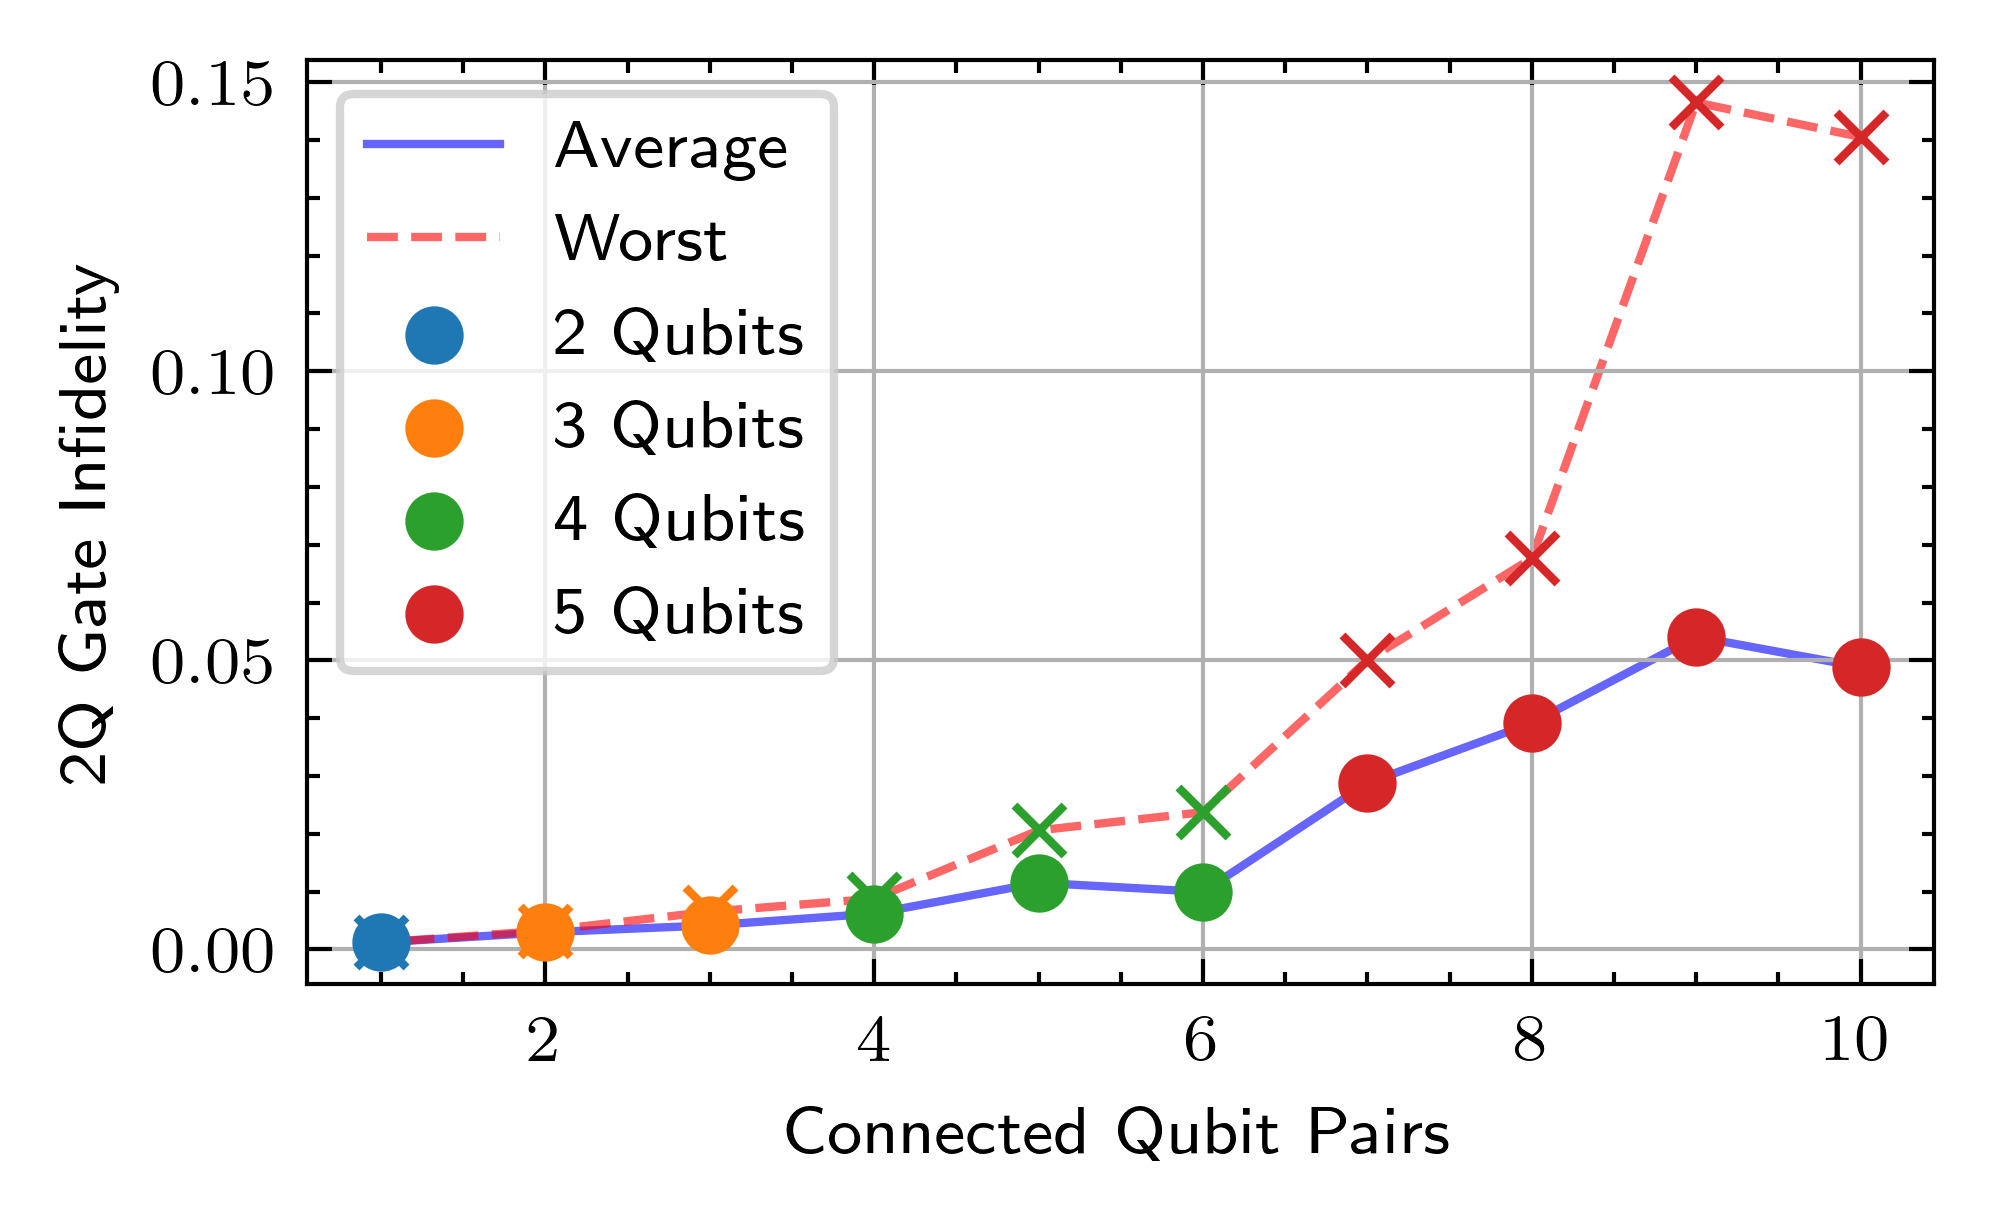

In [11]:
import matplotlib.pyplot as plt
import numpy as np

gate_counts = [x[0] * (x[0] - 1) // 2 - x[1] for x in module_list]
num_qubits = [x[0] for x in module_list]

# Sort the data by gate count in descending order
sorted_indices = np.argsort(gate_counts)[::-1]  # Reverse order

gate_counts = np.array(gate_counts)[sorted_indices]
averages = np.array(averages)[sorted_indices]
worsts = np.array(worsts)[sorted_indices]
num_qubits = np.array(num_qubits)[sorted_indices]

# Assign unique colors based on the number of qubits
unique_qubits = sorted(set(num_qubits))
# use tab10 colors
colors = plt.get_cmap("tab10").colors
color_map = {qubit: color for qubit, color in zip(unique_qubits, colors)}

# Plot raw data and damped decay fits
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 2))

    # Plot the continuous line through all points
    ax.plot(
        gate_counts,
        averages,
        linestyle="-",
        color="blue",
        alpha=0.6,
        zorder=1,
        label="Average",
    )
    ax.plot(
        gate_counts,
        worsts,
        linestyle="--",
        color="red",
        alpha=0.6,
        zorder=1,
        label="Worst",
    )

    # Scatter plot with different colors for each qubit count
    for qubit, color in color_map.items():
        indices = [i for i, q in enumerate(num_qubits) if q == qubit]
        ax.scatter(
            [gate_counts[i] for i in indices],
            [averages[i] for i in indices],
            color=color,
            label=f"{qubit} Qubits",
            zorder=2,
        )
        ax.scatter(
            [gate_counts[i] for i in indices],
            [worsts[i] for i in indices],
            color=color,
            marker="x",
            zorder=3,
        )

    ax.set_xlabel("Connected Qubit Pairs")
    ax.set_ylabel("2Q Gate Infidelity")
    ax.legend(frameon=True)
    ax.grid(True)

plt.savefig("../../img/average_infidelity.pdf", bbox_inches="tight")
plt.show()